In [1]:
HQA_MNIST_SAVE_PATH = './checkpoints/hqa_mnist.pt'
CLASSIFIER_MNIST_SAVE_PATH = './checkpoints/lenet_mnist.pt'


In [2]:
import torch
import torchattacks
from torchvision.transforms import ToPILImage
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

import os

from hqa_lightning import train_hqa_mnist, HQA2D_Lightning
from lenet5 import LeNet5
from data import get_mnist_dataloaders, get_preds


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
dl_train, dl_test = get_mnist_dataloaders()

Device:  cuda


In [3]:
if os.path.exists(HQA_MNIST_SAVE_PATH):
    hqa_model = torch.load(HQA_MNIST_SAVE_PATH).to(device)
    print(f"Loaded {len(hqa_model)} layer model from checkpoint.")
else:
    hqa_model = train_hqa_mnist(max_epochs=50, devices=1)
    torch.save(hqa_model, HQA_MNIST_SAVE_PATH)

def reconstruct(layer, attack=None):
    def _reconstruct(x, y):
        if attack is not None:
            x = attack(x, y)
        if layer >= 0:
            x = x.to(hqa_model.device)
            x_recon = hqa_model[layer].reconstruct(x)
            return x_recon
        return x
    return _reconstruct

Loaded 5 layer model from checkpoint.


In [4]:
if os.path.exists(CLASSIFIER_MNIST_SAVE_PATH):
    lenet_model = torch.load(CLASSIFIER_MNIST_SAVE_PATH).to(device)
    print(f"Loaded MNIST classifier from checkpoint.")
else:
    print("Classifier checkpoint not found!")

Loaded MNIST classifier from checkpoint.


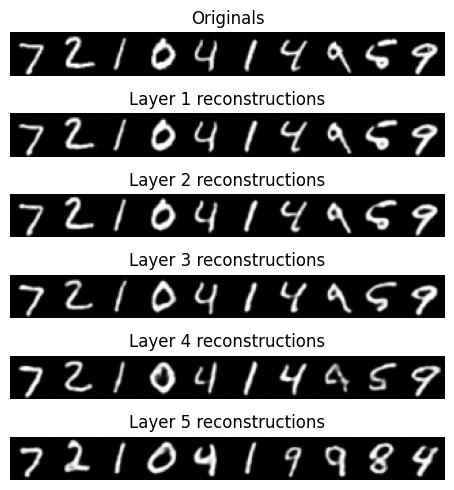

In [5]:
num_recons = 10

toImage = ToPILImage()

x, _ = next(iter(dl_test))
x = x[:num_recons]

originals = np.concatenate([toImage(img) for img in x], axis=1)
fig, ax = plt.subplots(ncols=1, nrows=len(hqa_model) + 1, figsize=(8,5))

ax[0].imshow(originals, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Originals")

for layer_index, layer in enumerate(hqa_model):
    x = x.to(hqa_model.device)
    recons = layer.reconstruct(x)
    recons = recons.cpu()
    recons_img = np.concatenate([toImage(recon) for recon in recons], axis=1)
    
    ax[layer_index + 1].imshow(recons_img, cmap='gray')
    ax[layer_index+ 1].axis("off")
    ax[layer_index + 1].set_title(f"Layer {layer_index+1} reconstructions")

fig.tight_layout()
plt.show()

In [6]:
accuracies_no_attack = []

Y, Y_pred = get_preds(lenet_model, dl_test)
accuracy = accuracy_score(Y,Y_pred)
print("Original Data Classification Accuracy: ", accuracy)
accuracies_no_attack.append(accuracy)

for index, layer in enumerate(hqa_model):
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(index))
    accuracy = accuracy_score(Y,Y_pred)
    accuracies_no_attack.append(accuracy)
    print(f"Layer {index} Reconstructions Classification Accuracy: ", accuracy)

Original Data Classification Accuracy:  0.9912
Layer 0 Reconstructions Classification Accuracy:  0.99
Layer 1 Reconstructions Classification Accuracy:  0.9867
Layer 2 Reconstructions Classification Accuracy:  0.9501
Layer 3 Reconstructions Classification Accuracy:  0.8524
Layer 4 Reconstructions Classification Accuracy:  0.7179


In [7]:
accuracies_fgsm_attack_01 = []
accuracies_fgsm_attack_05 = []
accuracies_fgsm_attack_07 = []
accuracies_fgsm_attack_10 = []
accuracies_fgsm_attack_20 = []

epsilons = [0.01, 0.05, 0.07, 0.1, 0.2]

eps_to_array = {
    0.01 : accuracies_fgsm_attack_01,
    0.05 : accuracies_fgsm_attack_05,
    0.07 : accuracies_fgsm_attack_07,
    0.1 : accuracies_fgsm_attack_10,
    0.2 : accuracies_fgsm_attack_20
}

for epsilon in epsilons:
    attack = torchattacks.FGSM(lenet_model, eps=epsilon)
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(-1, attack=attack))
    accuracy = accuracy_score(Y,Y_pred)
    print(f"Attack [FGSM eps={epsilon}] Accuracy: ", accuracy)
    eps_to_array[epsilon].append(accuracy)
    for index, layer in enumerate(hqa_model):
        Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(index, attack=attack))
        accuracy = accuracy_score(Y,Y_pred)
        eps_to_array[epsilon].append(accuracy)
        print(f"Layer {index} Reconstructions [FGSM eps={epsilon}] Accuracy: ", accuracy)

Attack [FGSM eps=0.01] Accuracy:  0.9785
Layer 0 Reconstructions [FGSM eps=0.01] Accuracy:  0.9878
Layer 1 Reconstructions [FGSM eps=0.01] Accuracy:  0.9831
Layer 2 Reconstructions [FGSM eps=0.01] Accuracy:  0.9498
Layer 3 Reconstructions [FGSM eps=0.01] Accuracy:  0.8513
Layer 4 Reconstructions [FGSM eps=0.01] Accuracy:  0.7186
Attack [FGSM eps=0.05] Accuracy:  0.8576
Layer 0 Reconstructions [FGSM eps=0.05] Accuracy:  0.9709
Layer 1 Reconstructions [FGSM eps=0.05] Accuracy:  0.9722
Layer 2 Reconstructions [FGSM eps=0.05] Accuracy:  0.9303
Layer 3 Reconstructions [FGSM eps=0.05] Accuracy:  0.8373
Layer 4 Reconstructions [FGSM eps=0.05] Accuracy:  0.7097
Attack [FGSM eps=0.07] Accuracy:  0.7742
Layer 0 Reconstructions [FGSM eps=0.07] Accuracy:  0.951
Layer 1 Reconstructions [FGSM eps=0.07] Accuracy:  0.9634
Layer 2 Reconstructions [FGSM eps=0.07] Accuracy:  0.9162
Layer 3 Reconstructions [FGSM eps=0.07] Accuracy:  0.8249
Layer 4 Reconstructions [FGSM eps=0.07] Accuracy:  0.7087
Attack [

In [8]:
accuracies_bim_attack_01 = []
accuracies_bim_attack_05 = []
accuracies_bim_attack_07 = []
accuracies_bim_attack_10 = []
accuracies_bim_attack_20 = []

epsilons = [0.01, 0.05, 0.07, 0.1, 0.2]
arrays = [accuracies_bim_attack_01, accuracies_bim_attack_05, accuracies_bim_attack_07, accuracies_bim_attack_10, accuracies_bim_attack_20]

# BIM Attack
for epsilon, array in zip(epsilons, arrays):
    attack = torchattacks.BIM(lenet_model, eps=epsilon, alpha=2/255, steps=10)
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(-1, attack=attack))
    accuracy = accuracy_score(Y,Y_pred)
    print(f"Attack [BIM eps={epsilon}] Accuracy: ", accuracy)
    array.append(accuracy)
    for index, layer in enumerate(hqa_model):
        Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(index, attack=attack))
        accuracy = accuracy_score(Y,Y_pred)
        array.append(accuracy)
        print(f"Layer {index} Reconstructions [BIM eps={epsilon}] Accuracy: ", accuracy)

Attack [BIM eps=0.01] Accuracy:  0.9774
Layer 0 Reconstructions [BIM eps=0.01] Accuracy:  0.9872
Layer 1 Reconstructions [BIM eps=0.01] Accuracy:  0.9839
Layer 2 Reconstructions [BIM eps=0.01] Accuracy:  0.9457
Layer 3 Reconstructions [BIM eps=0.01] Accuracy:  0.8511
Layer 4 Reconstructions [BIM eps=0.01] Accuracy:  0.7212
Attack [BIM eps=0.05] Accuracy:  0.6959
Layer 0 Reconstructions [BIM eps=0.05] Accuracy:  0.9703
Layer 1 Reconstructions [BIM eps=0.05] Accuracy:  0.972
Layer 2 Reconstructions [BIM eps=0.05] Accuracy:  0.9328
Layer 3 Reconstructions [BIM eps=0.05] Accuracy:  0.834
Layer 4 Reconstructions [BIM eps=0.05] Accuracy:  0.7109
Attack [BIM eps=0.07] Accuracy:  0.5264
Layer 0 Reconstructions [BIM eps=0.07] Accuracy:  0.953
Layer 1 Reconstructions [BIM eps=0.07] Accuracy:  0.9635
Layer 2 Reconstructions [BIM eps=0.07] Accuracy:  0.9246
Layer 3 Reconstructions [BIM eps=0.07] Accuracy:  0.8328
Layer 4 Reconstructions [BIM eps=0.07] Accuracy:  0.708
Attack [BIM eps=0.1] Accuracy

In [9]:
accuracies_pgd_attack_01 = []
accuracies_pgd_attack_05 = []
accuracies_pgd_attack_07 = []
accuracies_pgd_attack_10 = []
accuracies_pgd_attack_20 = []


overshoots = [0.01, 0.05, 0.07, 0.1, 0.2]
arrays = [accuracies_pgd_attack_01, accuracies_pgd_attack_05, accuracies_pgd_attack_07, accuracies_pgd_attack_10, accuracies_pgd_attack_20]

# pgd Attack
for overshoot, array in zip(overshoots, arrays):
    attack = torchattacks.PGD(lenet_model, eps=overshoot)
    x, y = next(iter(dl_test))
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(-1, attack=attack))
    accuracy = accuracy_score(Y,Y_pred)
    print(f"Attack [pgd overshoot={overshoot}] Accuracy: ", accuracy)
    array.append(accuracy)
    for index, layer in enumerate(hqa_model):
        Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(index, attack=attack))
        accuracy = accuracy_score(Y,Y_pred)
        array.append(accuracy)
        print(f"Layer {index} Reconstructions [pgd overshoot={overshoot}] Accuracy: ", accuracy)

Attack [pgd overshoot=0.01] Accuracy:  0.9777
Layer 0 Reconstructions [pgd overshoot=0.01] Accuracy:  0.9876
Layer 1 Reconstructions [pgd overshoot=0.01] Accuracy:  0.985
Layer 2 Reconstructions [pgd overshoot=0.01] Accuracy:  0.9499
Layer 3 Reconstructions [pgd overshoot=0.01] Accuracy:  0.8458
Layer 4 Reconstructions [pgd overshoot=0.01] Accuracy:  0.7153
Attack [pgd overshoot=0.05] Accuracy:  0.7061
Layer 0 Reconstructions [pgd overshoot=0.05] Accuracy:  0.9714
Layer 1 Reconstructions [pgd overshoot=0.05] Accuracy:  0.9735
Layer 2 Reconstructions [pgd overshoot=0.05] Accuracy:  0.9329
Layer 3 Reconstructions [pgd overshoot=0.05] Accuracy:  0.8398
Layer 4 Reconstructions [pgd overshoot=0.05] Accuracy:  0.712
Attack [pgd overshoot=0.07] Accuracy:  0.5516
Layer 0 Reconstructions [pgd overshoot=0.07] Accuracy:  0.9601
Layer 1 Reconstructions [pgd overshoot=0.07] Accuracy:  0.9666
Layer 2 Reconstructions [pgd overshoot=0.07] Accuracy:  0.9245
Layer 3 Reconstructions [pgd overshoot=0.07] 

[0.9912, 0.99, 0.9867, 0.9501, 0.8524, 0.7179]
[0.9785, 0.9878, 0.9831, 0.9498, 0.8513, 0.7186]
[0.8576, 0.9709, 0.9722, 0.9303, 0.8373, 0.7097]
[0.7742, 0.951, 0.9634, 0.9162, 0.8249, 0.7087]
[0.6438, 0.9026, 0.9368, 0.8598, 0.7823, 0.6903]
[0.3331, 0.5406, 0.7044, 0.5386, 0.5711, 0.5633]


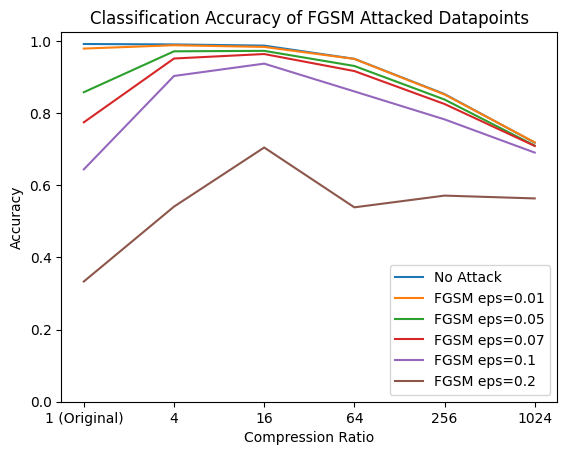

In [10]:
print(accuracies_no_attack)
print(accuracies_fgsm_attack_01)
print(accuracies_fgsm_attack_05)
print(accuracies_fgsm_attack_07)
print(accuracies_fgsm_attack_10)
print(accuracies_fgsm_attack_20)

layers = ["1 (Original)", "4", "16", "64", "256", "1024"]
plt.plot(layers, accuracies_no_attack, label="No Attack")
plt.plot(layers, accuracies_fgsm_attack_01, label="FGSM eps=0.01")
plt.plot(layers, accuracies_fgsm_attack_05, label="FGSM eps=0.05")
plt.plot(layers, accuracies_fgsm_attack_07, label="FGSM eps=0.07")
plt.plot(layers, accuracies_fgsm_attack_10, label="FGSM eps=0.1")
plt.plot(layers, accuracies_fgsm_attack_20, label="FGSM eps=0.2")

plt.title("Classification Accuracy of FGSM Attacked Datapoints")
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")
plt.ylim(0)
plt.legend()

plt.savefig("./resources/mnist_fgsm_reconstructions.png")
plt.show()

[0.9912, 0.99, 0.9867, 0.9501, 0.8524, 0.7179]
[0.9774, 0.9872, 0.9839, 0.9457, 0.8511, 0.7212]
[0.6959, 0.9703, 0.972, 0.9328, 0.834, 0.7109]
[0.5264, 0.953, 0.9635, 0.9246, 0.8328, 0.708]
[0.4883, 0.9408, 0.9585, 0.9211, 0.8252, 0.7098]
[0.4857, 0.942, 0.9571, 0.9192, 0.8239, 0.7091]


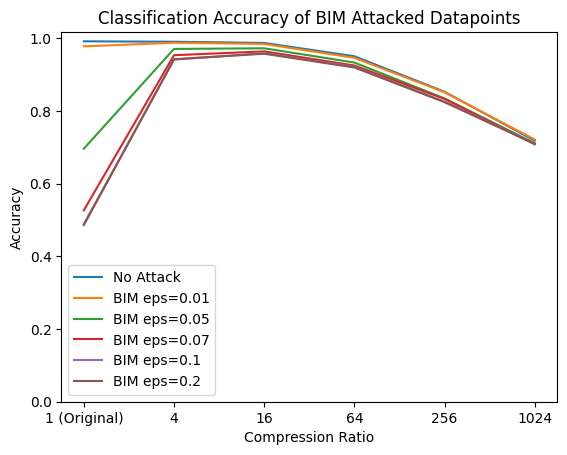

In [11]:
print(accuracies_no_attack)
print(accuracies_bim_attack_01)
print(accuracies_bim_attack_05)
print(accuracies_bim_attack_07)
print(accuracies_bim_attack_10)
print(accuracies_bim_attack_20)

layers = ["1 (Original)", "4", "16", "64", "256", "1024"]
plt.plot(layers, accuracies_no_attack, label="No Attack")
plt.plot(layers, accuracies_bim_attack_01, label="BIM eps=0.01")
plt.plot(layers, accuracies_bim_attack_05, label="BIM eps=0.05")
plt.plot(layers, accuracies_bim_attack_07, label="BIM eps=0.07")
plt.plot(layers, accuracies_bim_attack_10, label="BIM eps=0.1")
plt.plot(layers, accuracies_bim_attack_20, label="BIM eps=0.2")

plt.title("Classification Accuracy of BIM Attacked Datapoints")
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")
plt.ylim(0)
plt.legend()
plt.savefig("./resources/mnist_bim_reconstructions.png")
plt.show()

[0.9912, 0.99, 0.9867, 0.9501, 0.8524, 0.7179]
[0.9777, 0.9876, 0.985, 0.9499, 0.8458, 0.7153]
[0.7061, 0.9714, 0.9735, 0.9329, 0.8398, 0.712]
[0.5516, 0.9601, 0.9666, 0.9245, 0.8289, 0.7099]
[0.4322, 0.9459, 0.9613, 0.9086, 0.8175, 0.7074]


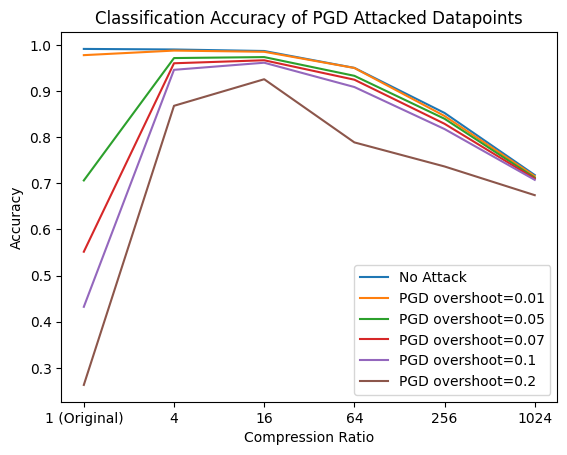

In [12]:
print(accuracies_no_attack)
print(accuracies_pgd_attack_01)
print(accuracies_pgd_attack_05)
print(accuracies_pgd_attack_07)
print(accuracies_pgd_attack_10)

layers = ["1 (Original)", "4", "16", "64", "256", "1024"]
plt.plot(layers, accuracies_no_attack, label="No Attack")
plt.plot(layers, accuracies_pgd_attack_01, label="PGD overshoot=0.01")
plt.plot(layers, accuracies_pgd_attack_05, label="PGD overshoot=0.05")
plt.plot(layers, accuracies_pgd_attack_07, label="PGD overshoot=0.07")
plt.plot(layers, accuracies_pgd_attack_10, label="PGD overshoot=0.1")
plt.plot(layers, accuracies_pgd_attack_20, label="PGD overshoot=0.2")

plt.title("Classification Accuracy of PGD Attacked Datapoints")
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")
plt.legend()
plt.savefig("./resources/mnist_pgd_reconstructions.png")
plt.show()

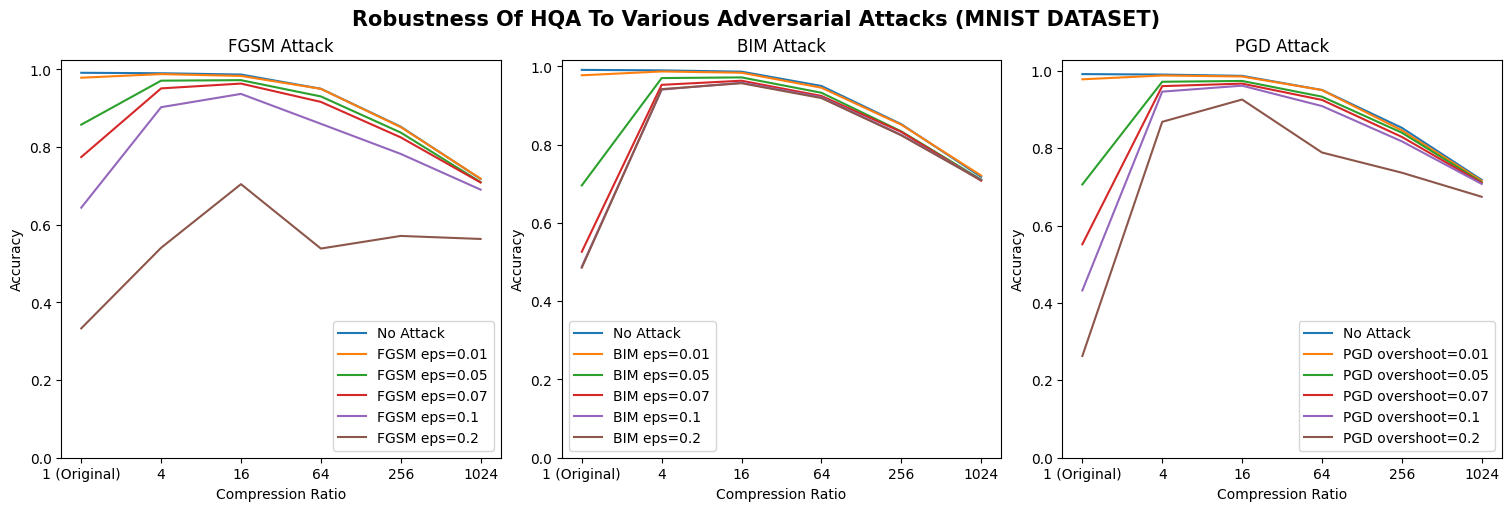

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3, constrained_layout=True, figsize=(15,5))
fig.suptitle("Robustness Of HQA To Various Adversarial Attacks (MNIST DATASET)", fontweight="bold", fontsize=15)
layers = ["1 (Original)", "4", "16", "64", "256", "1024"]
ax1.plot(layers, accuracies_no_attack, label="No Attack")
ax1.plot(layers, accuracies_fgsm_attack_01, label="FGSM eps=0.01")
ax1.plot(layers, accuracies_fgsm_attack_05, label="FGSM eps=0.05")
ax1.plot(layers, accuracies_fgsm_attack_07, label="FGSM eps=0.07")
ax1.plot(layers, accuracies_fgsm_attack_10, label="FGSM eps=0.1")
ax1.plot(layers, accuracies_fgsm_attack_20, label="FGSM eps=0.2")

ax1.set_title("FGSM Attack")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Compression Ratio")
ax1.set_ylim(0)
ax1.legend()

ax2.plot(layers, accuracies_no_attack, label="No Attack")
ax2.plot(layers, accuracies_bim_attack_01, label="BIM eps=0.01")
ax2.plot(layers, accuracies_bim_attack_05, label="BIM eps=0.05")
ax2.plot(layers, accuracies_bim_attack_07, label="BIM eps=0.07")
ax2.plot(layers, accuracies_bim_attack_10, label="BIM eps=0.1")
ax2.plot(layers, accuracies_bim_attack_20, label="BIM eps=0.2")

ax2.set_title("BIM Attack")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Compression Ratio")
ax2.set_ylim(0)
ax2.legend()

ax3.plot(layers, accuracies_no_attack, label="No Attack")
ax3.plot(layers, accuracies_pgd_attack_01, label="PGD overshoot=0.01")
ax3.plot(layers, accuracies_pgd_attack_05, label="PGD overshoot=0.05")
ax3.plot(layers, accuracies_pgd_attack_07, label="PGD overshoot=0.07")
ax3.plot(layers, accuracies_pgd_attack_10, label="PGD overshoot=0.1")
ax3.plot(layers, accuracies_pgd_attack_20, label="PGD overshoot=0.2")

ax3.set_title("PGD Attack")
ax3.set_ylabel("Accuracy")
ax3.set_xlabel("Compression Ratio")
ax3.set_ylim(0)
ax3.legend()
plt.savefig("./resources/mnist_attack_plots.png")

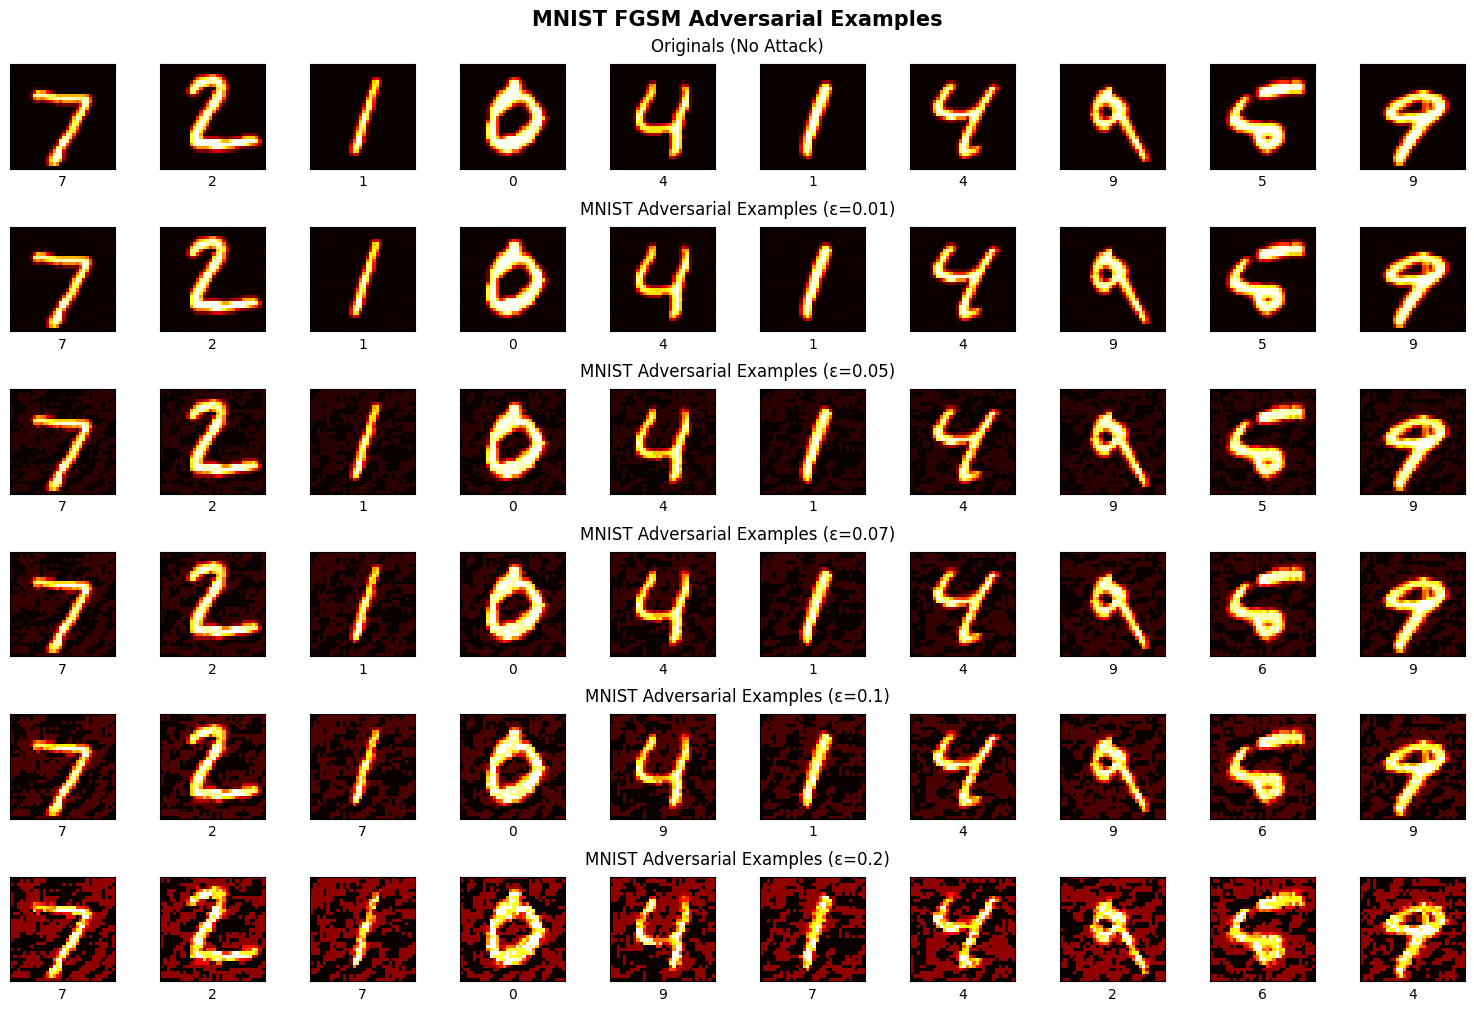

In [14]:
num_recons = 10

toImage = ToPILImage()
dataset = dl_test.dataset

epsilons = [0.01, 0.05, 0.07, 0.1, 0.2]

# create 3x1 subplots
fig, axs = plt.subplots(nrows=len(epsilons) + 1, ncols=1, constrained_layout=True, figsize=(15,10))
fig.suptitle('MNIST FGSM Adversarial Examples', fontweight="bold", fontsize=15)

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=num_recons)
    if row == 0:
        subfig.suptitle(f'Originals (No Attack)')
        y_pred = lenet_model(x.to(lenet_model.device))[:num_recons]
        y_pred = y_pred.argmax(axis=1)
        y_pred = list(map(lambda label : label.item(), y_pred))
        for ndx, x_original in enumerate(x[:num_recons]):
            axis = axs[ndx]
            original_img = toImage(x_original)
            axis.get_yaxis().set_ticks([])
            axis.get_xaxis().set_ticks([])
            axis.imshow(original_img, cmap='hot')
            axis.set_xlabel(y_pred[ndx])
    else:
        epsilon = epsilons[row - 1]
        subfig.suptitle(f'MNIST Adversarial Examples (ε={epsilon})')
        attack = torchattacks.FGSM(lenet_model, eps=epsilon)
        attacked_x = attack(x,y)
        attacked_y_pred = lenet_model(attacked_x.to(lenet_model.device))[:num_recons]
        attacked_y_pred = attacked_y_pred.argmax(axis=1)
        attacked_y_pred = list(map(lambda label : label.item(), attacked_y_pred))
        for img_ndx, x_attacked in enumerate(attacked_x[:num_recons]):
            axis = axs[img_ndx]
            attacked_img = toImage(x_attacked)
            axis.get_yaxis().set_ticks([])
            axis.get_xaxis().set_ticks([])
            axis.imshow(attacked_img, cmap='hot')
            axis.set_xlabel(attacked_y_pred[img_ndx])
plt.savefig("resources/mnist_fgsm.png")
plt.show()